# Analyzing Election Data

Code for testing examples from the paper [Stable Voting](https://arxiv.org/abs/2108.00542) by W. Holliday and E. Pacuit.  

In [1]:
# import the Profile class
from voting.profiles import Profile
from voting.profiles_with_ties import *

# import the voting methods
from voting.voting_methods import *

import math
import random
import pandas as pd
from itertools import product, combinations

from functools import partial
from multiprocess import Pool, cpu_count
import pickle
import timeit

from re import findall

import copy
import matplotlib.pyplot as plt
import seaborn as sns
import os
sns.set()


In [2]:
# Given a file in one of the Preflib Election Data 
# formats, return a list of rankmaps.
def read_election_file(inputfile, mult_rank_last = False):
    #first element is the number of candidates.
    l = inputfile.readline()
    numcands = int(l.strip())
    candmap = {}
    for i in range(numcands):
        bits = inputfile.readline().strip().split(",")
        candmap[int(bits[0].strip())] = bits[1].strip()
    #now we have numvoters, sumofvotecount, numunique orders
    bits = inputfile.readline().strip().split(",")
    numvoters = int(bits[0].strip())
    sumvotes = int(bits[1].strip())
    uniqueorders = int(bits[2].strip())
    
    rankmaps = []
    rankmapcounts = []
    
    for i in range(uniqueorders):
        rec = inputfile.readline().strip()
        #print(rec)
        new_rank = rec

        matches = findall(r',\{.*?\},', new_rank)
        for over_vote in matches: 
            new_rank = new_rank.replace(over_vote, ',')

        matches = findall(r',\{.*?\}', new_rank)

        for over_vote in matches: 
            new_rank = new_rank.replace(over_vote, '')

        matches = findall(r'\{.*?\},', new_rank)

        for over_vote in matches: 
            new_rank = new_rank.replace(over_vote, '')

        rec = new_rank
        #print("rec is ", rec)
        #need to parse the rec properly..
        if rec.find("{") == -1:

            if rec.find(",") == -1:
                count = int(rec)
                cvote = {c:1 for c in candmap.keys()}
            else:
                #its strict, just split on ,
                count = int(rec[:rec.index(",")])
                bits = rec[rec.index(",")+1:].strip().split(",")
                #print("bits is ", bits)
                cvote = {}
                crank = 1
                for _cidx in range(len(bits)): 
                    #print("crank is ", crank)
                    if mult_rank_last or int(bits[_cidx]) not in cvote.keys():
                        cvote[int(bits[_cidx])] = crank
                        crank += 1
                max_rank = max(cvote.values())

                for c in candmap.keys():
                    if c not in cvote.keys():
                        cvote[c] = max_rank + 1
            #print("cvote is ", cvote)
            rankmaps.append(cvote)
            rankmapcounts.append(count)
    
    return candmap, rankmaps, rankmapcounts, numvoters


In [3]:
## generate a margin graph from an preflib data eleciton file

def gen_mg_from_election_data(fname):

    candmap, rankmaps, rankmapcounts, numvoters = read_election_file_new(open(fname, "r"), mult_rank_last = False)
    
    mg = nx.DiGraph()
    mg.add_nodes_from([c-1 for c in candmap.keys()])
    for c1 in candmap.keys(): 
        for c2 in candmap.keys():
            if c1 != c2: 
                p_c1_c2 = 0
                p_c2_c1 = 0
                for ridx,r in enumerate(rankmaps): 
                    if r[c1] < r[c2]:
                        p_c1_c2 += rankmapcounts[ridx]
                    elif r[c1] > r[c2]: 
                        p_c2_c1 += rankmapcounts[ridx]
                    #else: # r[c1] < r[c2]
                if p_c1_c2 > p_c2_c1: 
                    mg.add_weighted_edges_from([(c1-1,c2-1, p_c1_c2 - p_c2_c1)])
                elif p_c2_c1 > p_c1_c2: 
                    mg.add_weighted_edges_from([(c2-1,c1-1, p_c2_c1 - p_c1_c2)])
    return mg


## Example 3.2: 2007 Glasgow City Council election for Ward 5

The candidates: 
1: Shaukat Butt
2: Michael Cobley
3: Stephen Dornan
4: John Flanagan
5: Alan L Hughes
6: Allison Hunter
7: Will Jess
8: Irene Lang
9: Patricia Mcintyre
10: George Douglas Mcnee
11: Carolina Perez


There is no Condorcet winner
The Smith set is:  Stephen Dornan, John Flanagan, Allison Hunter
Marging Graph


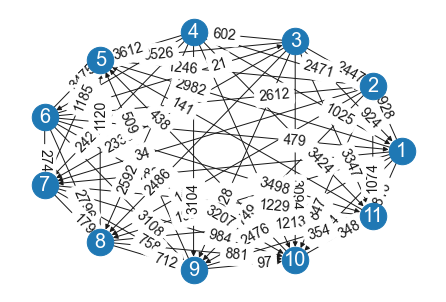

Margin Graph restricted to the Smith Set


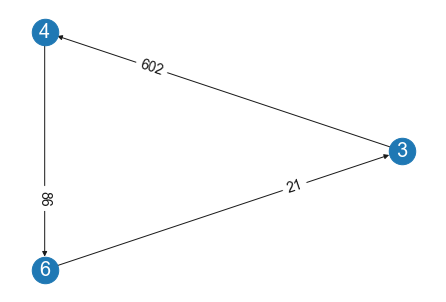

Stable Voting winners: Stephen Dornan
Split Cycle winners: Stephen Dornan
Beat Path winners: Stephen Dornan
Minimax winners: Stephen Dornan
Ranked Pairs winners: Stephen Dornan
Top Cycle winners: Stephen Dornan, John Flanagan, Allison Hunter


In [4]:
candmap, rankmaps, rankmapcounts, numvoters = read_election_file(open("./preflib-data/ED-00008-00000009.soi", "r"), mult_rank_last = False)


print("The candidates: ")
for cid,c in candmap.items():
    print(f"{cid}: {c}")

print("\n")

prof = ProfileWithTies(rankmaps, 6,  rcounts=rankmapcounts, cmap=candmap, candidates=candmap.keys())

cw = prof.condorcet_winner()
if cw is None: 
    print("There is no Condorcet winner")
else: 
    print(f"The Condorcet winner is {cw}")

smith_set = getcha(prof)
smith_set_ws = ", ".join([candmap[c] for c in smith_set])
print(f"The Smith set is:  {smith_set_ws}")

print("Marging Graph")
prof.display_margin_graph(cmap={c:str(c) for c in candmap.keys()})


print("Margin Graph restricted to the Smith Set")
reduced_prof, _ = prof.remove_candidates([c for c in prof.candidates if c not in smith_set])
reduced_prof.display_margin_graph(cmap={c:str(c) for c in candmap.keys()})

vms = [stable_voting, split_cycle,  beat_path, minimax, ranked_pairs, getcha]

for vm in vms: 
    
    ws = vm(prof)
    ws_str = ", ".join([candmap[w] for w in ws])
    print(f"{vm.name} winners: {ws_str}")
    


## Example 3.1:   2009 Mayoral Election in Burlington, Vermont

The candidates: 
1: Bob Kiss
2: Andy Montroll
3: James Simpson
4: Dan Smith
5: Kurt Wright
6: Write-In


The Condorcet winner is Andy Montroll
The Smith set is:  Andy Montroll
Marging Graph


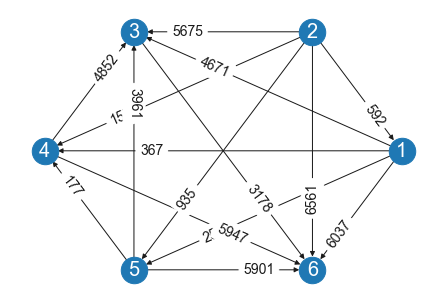

Margin Graph restricted to the Smith Set


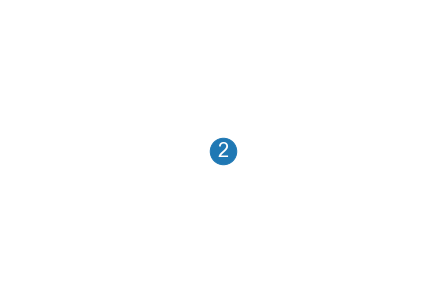

Stable Voting winners: Andy Montroll
Split Cycle winners: Andy Montroll
Beat Path winners: Andy Montroll
Minimax winners: Andy Montroll
Ranked Pairs winners: Andy Montroll
Top Cycle winners: Andy Montroll


In [5]:
candmap, rankmaps, rankmapcounts, numvoters = read_election_file(open("./preflib-data/ED-00005-00000002.toi", "r"), mult_rank_last = False)


print("The candidates: ")
for cid,c in candmap.items():
    print(f"{cid}: {c}")

print("\n")

prof = ProfileWithTies(rankmaps, 6,  rcounts=rankmapcounts, cmap=candmap, candidates=candmap.keys())

cw = prof.condorcet_winner()
if cw is None: 
    print("There is no Condorcet winner")
else: 
    print(f"The Condorcet winner is {candmap[cw]}")

smith_set = getcha(prof)
smith_set_ws = ", ".join([candmap[c] for c in smith_set])
print(f"The Smith set is:  {smith_set_ws}")

print("Marging Graph")
prof.display_margin_graph(cmap={c:str(c) for c in candmap.keys()})


print("Margin Graph restricted to the Smith Set")
reduced_prof, _ = prof.remove_candidates([c for c in prof.candidates if c not in smith_set])
reduced_prof.display_margin_graph(cmap={c:str(c) for c in candmap.keys()})

vms = [stable_voting, split_cycle,  beat_path, minimax, ranked_pairs, getcha]

for vm in vms: 
    
    ws = vm(prof)
    ws_str = ", ".join([candmap[w] for w in ws])
    print(f"{vm.name} winners: {ws_str}")
